# Analyzing the NYC High School SAT Score

## Table of Contents

- [Introduction](#intro)
- [Read in the data](#read)
- [Read in the surveys](#survey)
- [Add DBN columns](#dbn)
- [Convert columns to numeric](#numeric)
- [Condense datasets](#datasets)
- [Convert AP scores to numeric](#ap)
- [Combine the datasets](#combine)
- [Add a school district column for mapping](#school)
- [Find correlations](#corr)
- [Plotting survey correlations](#plot)
- [Exploring Safety and SAT Scores](#explore)
- [Exploring Race and SAT Scores](#race)
- [Exploring Gender and SAT Scores](#gender)
- [Exploring AP Scores vs. SAT Scores](#apsat)
- [Advanced Placement(AP) Test takers percentage by school](#advanced)
- [Class size and SAT score](#size)
- [Conclusion](#conclusion)

# Introduction <a  id="intro"></a>

We will analyze the factors affecting SAT scores of the NYC High Schools. We will look into different files and combine the data as per our need. 
The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic datasets. 
- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

# Read in the data<a id="read"></a>

In [114]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
# creating data files dictionary

data = {}

for f in data_files:
    key_name = f.replace(".csv", "")
    d = pd.read_csv(f"schools/{f}")
    data[key_name] = d
#     read into dataframe and create unique key to include into the data dictionary


# Read in the surveys<a id="survey"></a>

In [116]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
# reading survey data
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
# reading district data
survey = pd.concat([all_survey, d75_survey], axis=0)
# joining these two datasets into one ie. survey

survey = survey.copy()
survey["DBN"] = survey["dbn"]
# changing column dbn to DBN

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
# These are the fields that were used in survey

survey = survey[survey_fields]
# clean the dataset and keep only required survey fields
data["survey"] = survey
# adding the survey dataset to data dictionary

# Add DBN columns<a id="dbn"></a>

In [117]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]
# changing dbn column name in hs_directory to DBN

def pad_csd(num):
#     function to change numerical values into string and return the string

    string_representation = str(num)
    if len(string_representation) > 1:
#         if numerical value has more digits then 1 eg, 12, 322, etc. return the string
        return string_representation
    else:
        return "0" + string_representation
#     if the number is only made of one digit, ie, 1, 2, 7, 4, etc, return string, 01, 02, 07, 04
#     by adding 0 infront respectively 
# we need this to create the DBN column
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
# applying the function elementwise for CSD column from class_size dataset
# saving the returned values in a new column padded_csd in class_size

data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
# creating DBN column in class_size to merge the class_size dataset later on based on DBN that is common
# DBN in class size is obtained by adding two values from padded_csd and SCHOOL CODE for unique value

# Convert columns to numeric<a id="numeric"></a>

In [119]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
# need to convert these columns into numeric values, to find sat scores later on
# each column has weight of 800 schoes in total for individual fields, hence, values are less than or equal to 800

for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")
#     errors="coerce", if values in the columns are not numeric, represent the value with NaN
# we will only deal with numeric values for SAT score

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]
# after all the sat score is the sum of the values present in the cols
# hence total weight is 2400, values should be less than 2400 for sat_score, 
# sat_score is a new column created by adding values in cols, for sat_results

def find_lat(loc):
#     function to find only latitude
    coords = re.findall("\(.+, .+\)", loc)
#     finding all the characters in the location between and including ( and )
    lat = coords[0].split(",")[0].replace("(", "")
#     removing brackets ( and only include first value by spliting values
    return lat

def find_lon(loc):
#     function to find only longitude
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
# create lat column in hs_directory, keep only latitude values by refining Location 1 column
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")
# numeric conversion for lat and lon column values

# Condense datasets<a id="datasets"></a>

In [120]:
class_size = data["class_size"]
# class_size dataset from data dictionary to work on cleaning

class_size = class_size[class_size["GRADE "] == "09-12"]
# we only need data for grades 9-12, ie, high school, who take the SAT for college admission

class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
# we only need GEN ED data from class_size

class_size = class_size.groupby("DBN").agg('mean', numeric_only=True)
# since DBN values are multiple we need to aggregate the values with the mean value based on DBN

class_size.reset_index(inplace=True)
# changing DBN index into column one again since after groupby().agg() from above, DBN had been a index label

data["class_size"] = class_size
# updating class_size in data dictionary

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
# we only need data from demomgraphics that are based on dates 2011-2012, that was the latest 
# in the data set we hhave

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
# we need Cohort values from 2006 enrollment

data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]
# we need total cohort values only

# Convert AP scores to numeric<a id="ap"></a>

In [121]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
# these columns are needed to be converted into numeric type to clean data further

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")
#     convert into numeric data type, but, fill with NaN values if not convertable from ap_2010
# for these cols values

# Combine the datasets<a id="combine"></a>

In [122]:
combined = data["sat_results"]
# we use combined variable to store a dataframe called sat_results from data dictionary

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
# merging ap_2010 with combined(ie. sat_results) with let join, based on DBN matching

combined = combined.merge(data["graduation"], on="DBN", how="left")
# merging graduation dataset with combined again with left join based on DBN values matching

to_merge = ["class_size", "demographics", "survey", "hs_directory"]
# these are other data set we have to be merged for further data cleaning and aggregate finding

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")
#     we merged with inner join because we only want to keep the data that are present in all the columns
# any values that are not matching in DBN column for all these columns are removed

combined = combined.fillna(combined.mean(numeric_only=True))
# we will fill the empty values for numeric columns in combined data set with mean value of those columns

combined = combined.infer_objects(copy=False).fillna(0)
# those values that are not filled yet for object data type are now filled with 0

# Add a school district column for mapping<a id="school"></a>

In [124]:
def get_first_two_chars(dbn):
    return dbn[0:2]
# to calculate school district numbers

combined = combined.copy()
# using copy is a good approach

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)
# create new column school_dist for school district values

combined['school_dist']

0      01
1      01
2      01
3      01
4      01
       ..
358    32
359    32
360    32
361    32
362    32
Name: school_dist, Length: 363, dtype: object

# Find correlations<a id="corr"></a>

In [125]:
correlations = combined.corr(numeric_only=True)
# pair wise correlation value for the columns in combined for only numerical columns

correlations = correlations["sat_score"]
# now we only want to see correlations of sat_score with all other columns

print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations<a id="plot"></a>

In [126]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
# we don't have to correlate the DBN with sat_score as DBN is not a numeric type

<Axes: >

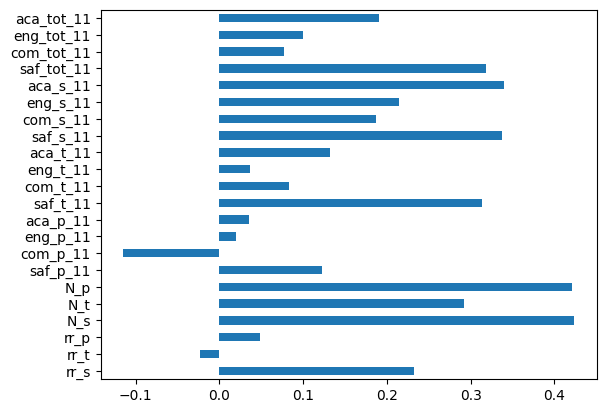

In [127]:
combined.corr(numeric_only=True)['sat_score'][survey_fields].plot.barh()
# survery fields correlations with sat_score that is what we need as the fields include the survey
# columns only

rr_t and com_p_11 are the columns with negative correlation, while all the other columns shows a positive correlation.

It seems N_p and N_s are highly correlated with survey_fields.

# Exploring Safety and SAT Scores<a id="explore"></a>

<Axes: xlabel='saf_s_11', ylabel='sat_score'>

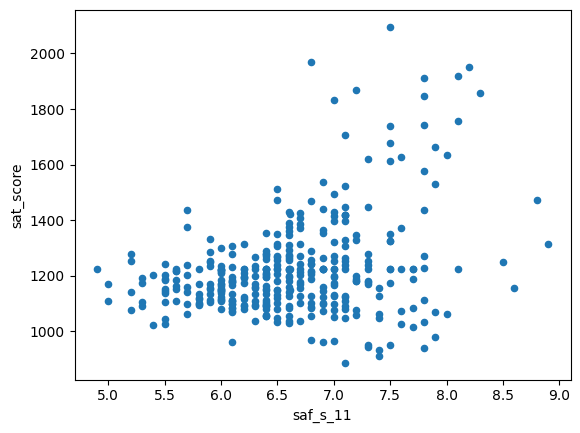

In [54]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

There is a correlation between safety and SAT scores. The correlation isn't that strong, though. There are some schools with high SAT scores and high safety scores.

In [55]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

In [128]:
# Average safety score for each borough

borough = combined.groupby('boro').agg('mean', numeric_only=True)['saf_s_11']
# we want to create borough of NYC based on safety score for 2011

borough

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

The safety score is almost same for all the 5 boroughs. Yet, the highest scores are obtained by Manhattan and Queens respectively. Lowesest among is seen in Brooklyn.
- Manhattan is home to the most famous skyline in the world, Manhattan is an icon. you find adventure everywhere, whether by the lights of Broadway or under the soaring elms of Central Park.
- Queens can satisfy nearly every taste and thrill. You can explore an endless selection of global cuisines, scenic surf, edgy galleries and World’s Fair remnants.
- There’s plenty to explore in NYC’s most populous borough, from world-class nightlife and innovative cuisine to brownstone-lined neighborhoods and expansive parks. This you can find in Brooklyn.

# Exploring Race and SAT Scores<a id="race"></a>

There are few columns indicating the percentage of each race at a given school they are:
- white_per
- asian_per
- black_per
- hispanic_per

Let's see the correlations between these columns and sat_score to determine there are any racial differences in SAT performance.

In [57]:
combined['white_per']

0       1.7
1       2.3
2      10.4
3       1.6
4      44.9
       ... 
358     0.7
359     1.8
360     1.0
361     1.5
362     0.0
Name: white_per, Length: 363, dtype: float64

<Axes: >

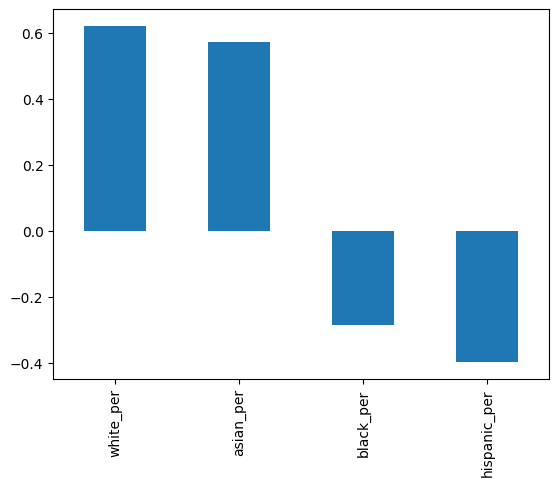

In [129]:
race_per = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
# we want to see if racial part alter the SAT scores

combined.corr(numeric_only=True)['sat_score'][race_per].plot.bar()

White and Asian racial communities have higher SAT scores showing the positive correlation with SAT score. Black and Hispanic communities are with negative correlation with lower SAT scores.

<Axes: xlabel='sat_score', ylabel='hispanic_per'>

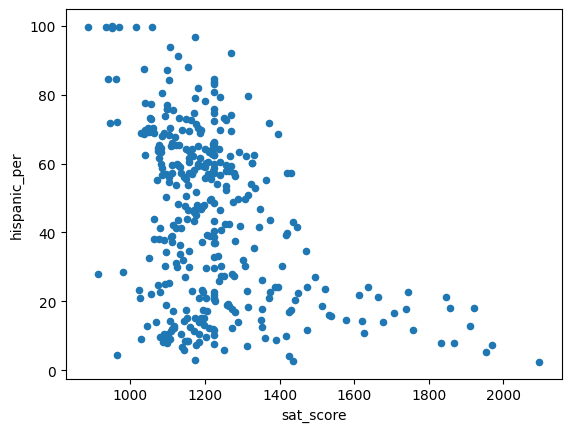

In [130]:
combined.plot.scatter(x='sat_score', y='hispanic_per')

Average hispanic communities obtain average score between 1000 to 1500, but, there are lesser percentage showing with high SAT scores.

<Axes: xlabel='sat_score', ylabel='hispanic_per'>

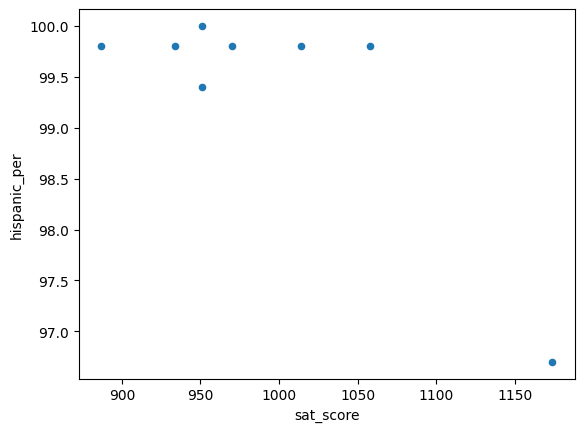

In [131]:
hispanic_95 = combined[combined['hispanic_per']>=95]
# hispanic_per greater than 95 only included

hispanic_95.plot.scatter('sat_score', 'hispanic_per')
# we want to see a relation with sat_score and hispanic_per column that has hispanic_per greater
# than 95

Only countable in numbers hispanic percentage greater or equal to 95 to achieve sat score.

In [61]:
hispanic_95.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

In [132]:
hispanic_95['SCHOOL NAME']
# hispanic_per greater than 95 percentage
# we want to see the schools those included

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The hispanic_95 are the bilingual schools based on New York city for English Learners. It has focus on Spanish speakers.

In [133]:
# hispanic less than 10% with SAT over 1800
hispanic_1018 = combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]
# hispanic_per lesser than 10 and sat_score greater than 1800

<Axes: xlabel='hispanic_per', ylabel='sat_score'>

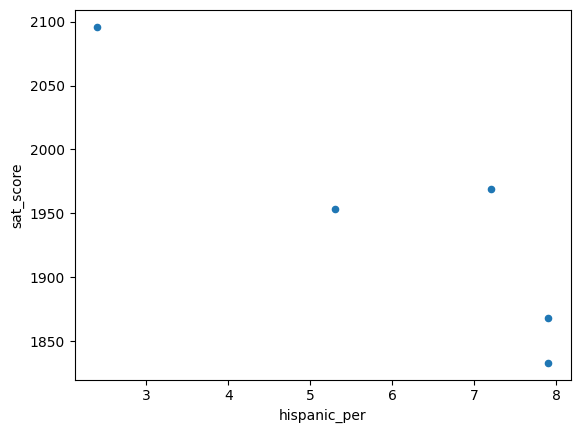

In [64]:
hispanic_1018.plot.scatter('hispanic_per', 'sat_score')

In [134]:
hispanic_1018['SCHOOL NAME']
# schools including hispanic race with lesser than 10 percent of hispanic race and who got 
# SAT score g reater than 1800/2400

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These are Specialized public high schools in the New York City for science and arts wehre talented students are supposed to be enrolled. They all take highly effective admission test for enrollment.

# Exploring Gender and SAT Scores<a id="gender"></a>

There are two columns that indicate the percentage of each gender at a school:
- male_per
- female_per

Let's plot out the correlations between each percentage and sat_score.

Text(0, 0.5, 'Gender')

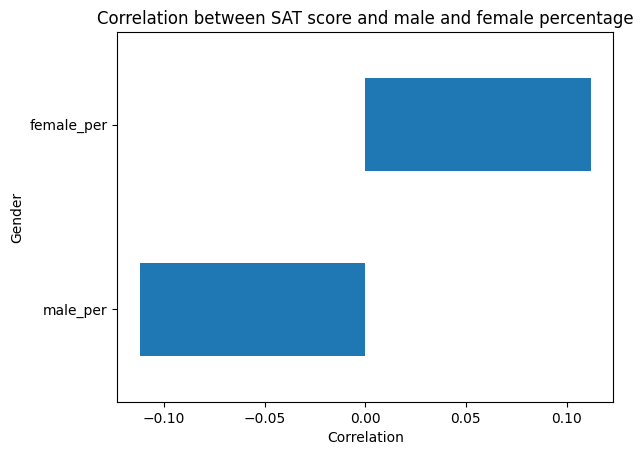

In [135]:
combined.corr(numeric_only=True)['sat_score'][['male_per', 'female_per']].plot.barh()
# see correlation of male_per and female_per with sat_score pairwise

plt.title('Correlation between SAT score and male and female percentage')
plt.xlabel('Correlation')
plt.ylabel('Gender')

Female percentage have positive correlation while Male percentage shows a negative correlation with SAT score.

<Axes: xlabel='female_per', ylabel='sat_score'>

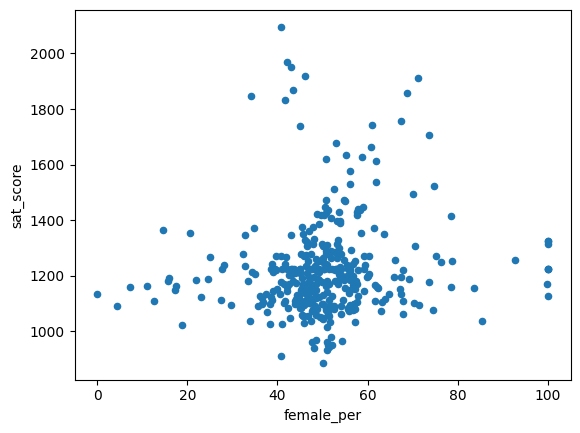

In [78]:
combined.plot.scatter('female_per', 'sat_score')

The scatter plot shows correlation between sat_score and female_per. It seems, 40 to 60 percent female category has SAT scores in between 1000 and 1400 in average. Over 2000 SAT score there are lesser number of females.

In [136]:
# female percentage greather than 60 and average SAT score greather than 1700
female_1760 = combined[(combined['female_per']>60) & (combined['sat_score']>1700)]
# for school which include female_per greater than 60 % and who obtained SAT score greater than 1700

female_1760['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools include diversity for their science and arts program rigorous academic programs. This suggest, the more schools are performing well with their curriculum, the more students tend to score high. Yet, these are not only the factors affecting student's SAT scores. But, it is also about their school culture where they get involved in different activities which help them thrive on their journey. 

# Exploring AP Scores vs. SAT Scores<a id="apsat"></a>

- In the U.S., high school students take [Advanced Placement](https://en.wikipedia.org/wiki/Advanced_Placement_exams) (AP) exams to earn college credit. There are AP exams for many different subjects.

- It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

## Advanced Placement(AP) Test takers percentage by school<a id="advanced"></a>

In [137]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment'] * 100
# ap percentage that is obtained by total ap test takers in total_enrolled students

combined['ap_per']

0      30.575556
1       9.898477
2       3.177258
3      35.157724
4      15.809051
         ...    
358     7.755776
359    29.730149
360    19.095477
361     2.661597
362     7.359307
Name: ap_per, Length: 363, dtype: float64

In [143]:
combined[combined['ap_per']==0]
# who did not take the ap test?

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per


It shows every for every schools that are included in the survey have students who took the AP test.

<Axes: xlabel='sat_score', ylabel='ap_per'>

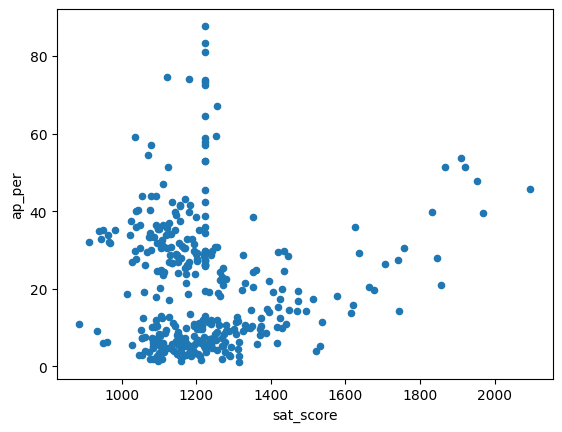

In [84]:
combined.plot.scatter('sat_score', 'ap_per')

It is almost normal distribution and a positive relationship between ap test takers and SAT scores. As the Test takers percentage rise, the SAT scores are also seen to rise.

# Class size and SAT score <a id="size"></a>

In [101]:
class_size.columns

Index(['DBN', 'CSD', 'NUMBER OF STUDENTS / SEATS FILLED', 'NUMBER OF SECTIONS',
       'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS',
       'SCHOOLWIDE PUPIL-TEACHER RATIO'],
      dtype='object')

[Text(0, 0, 'Large'),
 Text(0, 1, 'Small'),
 Text(0, 2, 'Average'),
 Text(0, 3, 'Sections'),
 Text(0, 4, 'Seats_Filed')]

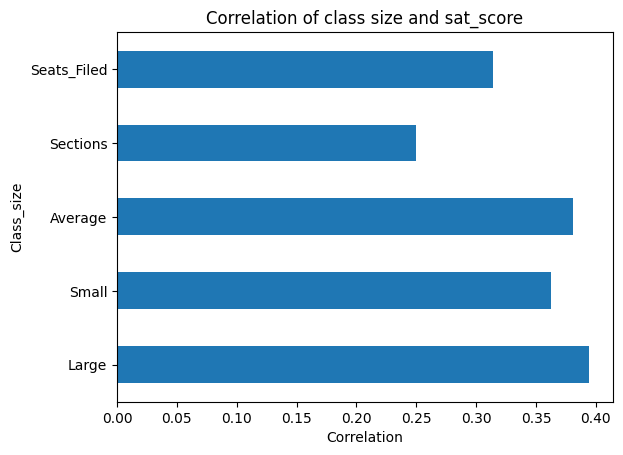

In [155]:
class_list = ['NUMBER OF STUDENTS / SEATS FILLED', 'NUMBER OF SECTIONS',
       'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS']
# class size list we want to see correlation with sat_score

ax = combined.corr(numeric_only=True)['sat_score'][class_list].plot.barh()
# creating oop interface

plt.title('Correlation of class size and sat_score')
# title for the chart

plt.xlabel('Correlation')
# setting label for x axis

plt.ylabel('Class_size')
# setting label for y axis

ax.set_yticklabels(['Large', 'Small', 'Average', 'Sections', 'Seats_Filed'])
# removing the long names from class_list for bar representation
# and adding rather short names to help focus in visualization

It shows a positive correlation for almost every fields that we have researched for the class_sizes and sat_score. It seems, the more number of students are present in the class, the higher SAT score is supposed to be attained.

# Conclusion<a id="conclusion"></a>

Many factors seem to affect the SAT score of students in NYC, however, it is also the High Schools they are studying that has affected the scores. Factors like rigorous programs and proper competition for enrollements in the schools are also major criteria to see. Yet, most of the public high schools with cultural diversity and bilinguality has also affected the SAT scores they obtain. The Science and Arts schools have scored higher SAT scores too. Furthremore, the class size has positively affected the SAT scores.